In [15]:
#Importing relevant libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns



In [16]:
features_df = pd.read_csv('features_dataset.csv')
features_df

,label,label.1,TTR,text_polarity,text_subjectivity,title_polarity,title_subjectivity,label.2,doc_perplexity,average_word_length,TTR_1_gram,TTR_3_gram
0,1,1,0.844037,0.091481,0.524184,-0.125000,0.125000,1,0.867938,6.490826,0.290036,0.344492
1,0,0,0.683438,0.003001,0.343395,0.000000,0.000000,0,0.882860,6.385744,0.234702,0.280710
2,1,1,0.721030,0.073622,0.401345,0.000000,1.000000,1,0.883760,6.072961,0.245223,0.292471
3,1,1,0.667638,0.037264,0.462935,0.000000,1.000000,1,0.882882,6.469388,0.224512,0.266710
4,1,1,0.628032,-0.018966,0.479310,-0.800000,0.900000,1,0.883120,6.296496,0.208015,0.247696
...,...,...,...,...,...,...,...,...,...,...,...,...
13829,0,0,0.659631,-0.030698,0.380595,0.000000,0.000000,0,0.882810,6.514512,0.222010,0.265742
13830,1,1,0.629126,-0.009035,0.312617,-0.066667,0.633333,1,0.895444,6.782524,0.209084,0.249022
13831,0,0,0.595745,0.049287,0.244648,0.000000,0.000000,0,0.883645,6.117021,0.204244,0.243178
13832,0,0,0.696581,-0.026939,0.293520,0.000000,0.000000,0,0.895276,6.478632,0.242472,0.290106


In [47]:
#Printing the datatypes to understand the different features
features_df.dtypes

label                    int64
label.1                  int64
TTR                    float64
text_polarity          float64
text_subjectivity      float64
title_polarity         float64
title_subjectivity     float64
label.2                  int64
doc_perplexity         float64
average_word_length    float64
TTR_1_gram             float64
TTR_3_gram             float64
dtype: object

In [17]:
features_df.drop(columns=['label.1', 'label.2'], inplace=True)
#Printing the datatypes to understand the different features
features_df.dtypes

label                    int64
TTR                    float64
text_polarity          float64
text_subjectivity      float64
title_polarity         float64
title_subjectivity     float64
doc_perplexity         float64
average_word_length    float64
TTR_1_gram             float64
TTR_3_gram             float64
dtype: object

# Relevant Data Preparation

As seen from above, 1_grams is not numerical, and therefore we need to convert it to numerical values to enable modelling with the entire dataset

We therefore start by cleaning the data, and then we seperate it into training and test sets

In [18]:
features_df

,label,TTR,text_polarity,text_subjectivity,title_polarity,title_subjectivity,doc_perplexity,average_word_length,TTR_1_gram,TTR_3_gram
0,1,0.844037,0.091481,0.524184,-0.125000,0.125000,0.867938,6.490826,0.290036,0.344492
1,0,0.683438,0.003001,0.343395,0.000000,0.000000,0.882860,6.385744,0.234702,0.280710
2,1,0.721030,0.073622,0.401345,0.000000,1.000000,0.883760,6.072961,0.245223,0.292471
3,1,0.667638,0.037264,0.462935,0.000000,1.000000,0.882882,6.469388,0.224512,0.266710
4,1,0.628032,-0.018966,0.479310,-0.800000,0.900000,0.883120,6.296496,0.208015,0.247696
...,...,...,...,...,...,...,...,...,...,...
13829,0,0.659631,-0.030698,0.380595,0.000000,0.000000,0.882810,6.514512,0.222010,0.265742
13830,1,0.629126,-0.009035,0.312617,-0.066667,0.633333,0.895444,6.782524,0.209084,0.249022
13831,0,0.595745,0.049287,0.244648,0.000000,0.000000,0.883645,6.117021,0.204244,0.243178
13832,0,0.696581,-0.026939,0.293520,0.000000,0.000000,0.895276,6.478632,0.242472,0.290106


In [19]:
# We then convert columns to numeric and furthermore look for negative values as these also needs to be normalized
def check_negatives(dataframe):
    negative_counts = {}
    for column in dataframe.columns:
        # Convert column to numeric, non-convertible values become NaN
        converted_column = pd.to_numeric(dataframe[column], errors='coerce')
        # Count negative values
        count = (converted_column < 0).sum()
        if count > 0:
            negative_counts[column] = count
    return negative_counts

# Apply the function to your DataFrame
negative_columns = check_negatives(features_df)

# Print the columns with negative values and their counts
print("Columns with negative values and their counts:")
for column, count in negative_columns.items():
    print(f"{column}: {count} negatives")

Columns with negative values and their counts:
text_polarity: 3097 negatives
title_polarity: 3117 negatives


In [20]:
def check_negatives_exclude_non_numeric(dataframe):
    negative_counts = {}
    for column in dataframe.columns:
        # Attempt to convert column to numeric
        converted_column = pd.to_numeric(dataframe[column], errors='coerce')
        # Continue only if the column is numeric
        if converted_column.dtype != 'object':
            # Count negative values
            count = (converted_column < 0).sum()
            if count > 0:
                negative_counts[column] = count
    return negative_counts

In [21]:
# Converting all columns to numeric, handling non-numeric gracefully
df = features_df.apply(pd.to_numeric, errors='coerce')

# Fill NaN values that result from conversion errors
df.fillna(0, inplace=True)

#Need
feature_columns = df.drop('label', axis=1).columns.tolist()


# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform the data to scale each feature to [0, 1] range
#df_scaled = scaler.fit_transform(df.drop('label', axis=1))

#We use this instead, to have data saved as dataframe. we had issues when it was saved as ndarray for feature importance calculation
df_scaled = pd.DataFrame(scaler.fit_transform(df.drop('label', axis=1)), columns=feature_columns)

# Split the data into features and target
X = df_scaled
y = df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MultinomialNB

In [53]:
# Initialize the Multinomial Naive Bayes classifier
model = MultinomialNB()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", report)

Accuracy: 0.6154680159016986
Confusion Matrix:
 [[948 405]
 [659 755]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.70      0.64      1353
           1       0.65      0.53      0.59      1414

    accuracy                           0.62      2767
   macro avg       0.62      0.62      0.61      2767
weighted avg       0.62      0.62      0.61      2767



Optimizing the model using gridsearch to increase performance

In [54]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score: {:.2f}".format(grid_search.best_score_))

# Evaluate using the best parameters
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.73
Test Accuracy: 0.7220816769063968
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.78      0.73      1353
           1       0.76      0.66      0.71      1414

    accuracy                           0.72      2767
   macro avg       0.73      0.72      0.72      2767
weighted avg       0.73      0.72      0.72      2767




Now we want to vizualise the confusion matrix as well

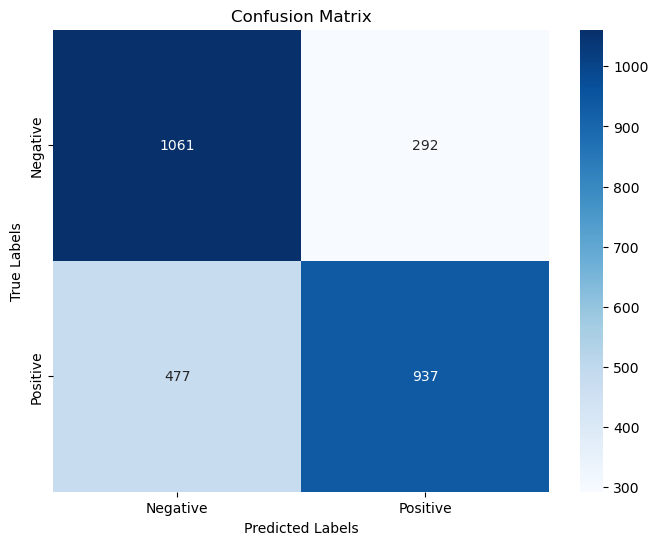

In [55]:
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Logistic Regression

In [56]:
# create and train model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

# make predictions
y_pred = logistic_regression_model.predict(X_test)

In [57]:
# performance metrics
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1353
           1       0.72      0.68      0.70      1414

    accuracy                           0.70      2767
   macro avg       0.70      0.70      0.70      2767
weighted avg       0.70      0.70      0.70      2767

Confusion Matrix:
 [[974 379]
 [449 965]]
Accuracy Score: 0.7007589447054572


### Tuning of Logistic Regression model

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model with 'liblinear' solver
logistic_regression = LogisticRegression(solver='liblinear')

# Create a dictionary of all values you want to test for C and penalty
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # The norm used in the penalization
}

# Use GridSearchCV to search for the best parameters
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the grid search model with your training data
grid_search.fit(X_train, y_train)

# Output the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ...................

/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time=   4.3s


/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time=   5.3s
[CV] END ...................................C=10, penalty=l1; total time=   7.1s
[CV] END ..................................C=100, penalty=l2; total time=   0.0s
[CV] END ..................................C=100, penalty=l2; total time=   0.0s
[CV] END ..................................C=100, penalty=l2; total time=   0.0s
[CV] END ..................................C=100, penalty=l2; total time=   0.0s
[CV] END ..................................C=100, penalty=l2; total time=   0.0s


/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...................................C=10, penalty=l1; total time=   7.8s
[CV] END ...................................C=10, penalty=l1; total time=   7.8s


/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...................................C=10, penalty=l1; total time=   7.1s


/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...................................C=10, penalty=l1; total time=   8.9s


/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time=   4.0s


/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time=  10.8s
[CV] END ..................................C=100, penalty=l1; total time=   9.7s
Best Parameters: {'C': 10, 'penalty': 'l2'}
Best Score: 0.7083216486630901


/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [59]:
# Using the best estimator to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output the evaluation results
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_mat)
print('Classification Report:\n', report)

Accuracy: 0.697867726779906
Confusion Matrix:
 [[968 385]
 [451 963]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.72      0.70      1353
           1       0.71      0.68      0.70      1414

    accuracy                           0.70      2767
   macro avg       0.70      0.70      0.70      2767
weighted avg       0.70      0.70      0.70      2767



In [60]:
# Assuming you have already trained your best model and obtained predictions
best_model = grid_search.best_estimator_

# Get coefficients and feature names
coefficients = best_model.coef_[0]
feature_names = X_train.columns

# Create a dictionary mapping feature names to coefficients
feature_importance = dict(zip(feature_names, coefficients))

# Sort feature importance by absolute coefficient value
sorted_importance = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# Display or further process sorted feature importance
for feature, importance in sorted_importance:
    print(f"Feature: {feature}, Importance: {importance}")


Feature: text_subjectivity, Importance: 7.124841202277942
Feature: TTR, Importance: 7.101795717168662
Feature: TTR_3_gram, Importance: -5.904626844732467
Feature: average_word_length, Importance: 5.512200215390377
Feature: text_polarity, Importance: -1.536578790737075
Feature: title_subjectivity, Importance: 1.425177310358259
Feature: title_polarity, Importance: -1.3272649971479944
Feature: TTR_1_gram, Importance: 0.8313812642194929
Feature: doc_perplexity, Importance: -0.5078843084614204


# Random Forest Model

In [61]:
# Train a Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Make predictions
y_pred = random_forest.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.795446331767257
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1353
           1       0.80      0.80      0.80      1414

    accuracy                           0.80      2767
   macro avg       0.80      0.80      0.80      2767
weighted avg       0.80      0.80      0.80      2767



Now we use gridSearch to find and use  the optimal hyperparameters, to increase the performance of the Random Forest model even more

In [62]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.7792536369386465
Accuracy: 0.7961691362486447
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1353
           1       0.80      0.80      0.80      1414

    accuracy                           0.80      2767
   macro avg       0.80      0.80      0.80      2767
weighted avg       0.80      0.80      0.80      2767



In [63]:
# Assuming you have already trained your best model and obtained predictions
best_model = grid_search.best_estimator_

# Get feature importances
importances = best_model.feature_importances_
feature_names = X_train.columns

# Create a dictionary mapping feature names to importances
feature_importance = dict(zip(feature_names, importances))

# Sort feature importance by importance score
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Display or further process sorted feature importance
for feature, importance in sorted_importance:
    print(f"Feature: {feature}, Importance: {importance}")


Feature: text_subjectivity, Importance: 0.24110998845859696
Feature: average_word_length, Importance: 0.11300880255967577
Feature: TTR, Importance: 0.10761234835995961
Feature: text_polarity, Importance: 0.10134741675457871
Feature: doc_perplexity, Importance: 0.09765136418947604
Feature: TTR_1_gram, Importance: 0.09392689579387281
Feature: TTR_3_gram, Importance: 0.09339685612708606
Feature: title_subjectivity, Importance: 0.08099930734557308
Feature: title_polarity, Importance: 0.07094702041118095


# SVM feature based model

Because 1_grams is text based it needs to be vectorized to enable the model to understand it.
Therefore we split the dataset in both numerical and text-based features, and the we vectorize the 1_grams.

In [22]:
# Initialize the SVM classifier
model_svm = SVC(kernel='linear', C=1.0)

# Train the SVM model
model_svm.fit(X_train, y_train)
# Predict the test set
predictions = model_svm.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))


Accuracy: 0.7011203469461511
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.74      0.71      1353
           1       0.73      0.66      0.69      1414

    accuracy                           0.70      2767
   macro avg       0.70      0.70      0.70      2767
weighted avg       0.70      0.70      0.70      2767



In [23]:
# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type to test
    'gamma': ['scale', 'auto']  # Gamma parameter for 'rbf' and 'poly' kernels
}

# Initialize GridSearchCV with the SVM classifier and parameter grid
grid_search = GridSearchCV(estimator=model_svm, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best SVM model from the grid search
best_svm = grid_search.best_estimator_

# Predict with the best SVM model on the test set
predictions = best_svm.predict(X_test)

# Evaluate the best SVM model
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))


KeyboardInterrupt: 